In [1]:
# imports

import pandas as pd
import numpy as np
import missingno

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy.interpolate import griddata
import math

# Lets see how far we can go using barometric pressure data as our sole data source


# assumptions and hypothesis: 

 Lets say there is a barometric-air-pressure-altering meteorological event taking place and during this event the pressure changes at a known location are being monitored.

#### Assumption 1: 
The barometric pressure at this location is dependent on the distance to the event center and this dependence should look similar to this: 

\begin{equation*}
P_i = P_i(r) = P_{base} - P_0 * m^{r}
\end{equation*}

with:

\begin{align}
\ r = \left | \vec{r}  \right | = \left | \vec{r_i} - \vec{r_0}  \right | = location\, distance\,  to\, event\, center\\
\vec{r_i} = location\, coordinates\\
\vec{r_0} = event\, center\, coordinates\\
P_i = location\,  presure\\
P_{base} = location\,  presure\, without\, event\, influence\\
P_{base} - P_0 = presure\, at\, event\, center\\
P_0 = some\, constant,\, 0 < P_0 \\
m = some\, constant,\, 0 < m < 1
\end{align}

#### Assumption 2: 
The event center is closest to the measuring location at the time of the lowest pressure at the measuring location. (follows from A1)

#### hypothesis:
If A1 and A2 are true and if we have measurements from multiple locations of the barometric air pressure during a meteorological event, then this will be enough to reconstruct the event and its progression!

## First thing we need to do is find a meteorological event that we can analyze. 

It needs to have a strong and distinct impact on the pressure data. It needs to take place over a period of otherwise relatively constant pressure, so that we can be reasonably sure that the changes in the pressure we are analyzing are indeed mostly caused by the event and not by outside factors. It would also help, if the event was relatively strong so that the influence of outside effects would be small in comparison. The event should also have a clear distinguishable beginning and end. And if our event were to last only for a short time, then the possibility of outside factors messing with our data during the event would be further reduced.



<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/low%20pressure%20area%20by%20nasa.bmp">  
Im not a meteorologist and so my knowledge of such events is limited. But I strongly assume that the passing of a low pressure area would drop the air pressure in that region. I further assume, that this drop would be relatively sharp and distinguishable, if the causing low pressure were strong enough. The drop from a strong event would also be registered by different stations at different times and with different intensities, allowing for reconstruction of its movement path and possibly also speed, strength and radius. 


So that is what we are going to look for – the passing of a strong, quickly moving area of low pressure – indicated by a strong, short-lived downward spike on the pressure/time diagram,  preferably inside a time interval of otherwise constant pressure. 


For the searching we are mostly going to rely on this website: 
http://www.mundomanz.com/meteo_p/mairgraph?year=2019&month=04&day=15&n_days=120&l=1&action=display 
It lets you access meteorological data of a weather station in Sevilla, Spain for years back and it also plots the data so that you can analyze it right on the site without downloading it. 


 

## The event on December, 2018 looks like a good candidate: 

It is a relatively strong pressure drop with a well recognizable beginning and end, a sharp low as well as some relatively clean fall and rise sections. 


![pic1.jpg](https://raw.githubusercontent.com/51ngularity/weather/master/images/sevilla12-2018.bmp)

## Lets first download the raw data of the event
And while we’re at it, we might want to find and download all the other data we are going to need later on as well, so that we can prepare all of it in one go. That means that we need to decide now how much data we are gonna need.


Its probably a good idea to get data from all across the region in order to get a full picture, but we also dont want to get more than we need, since we are going to download every file by hand. A good compromise might be to cover the region with a 5x5 grid and then see if we can find data for each square. The one with Sevilla we already covered, 24 more to go...


<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/Spain%20grid.bmp"> 

We will need to find a meteorological station and access its data for the relevant time-interval for each square.
For that we will be using this source: http://www.meteomanz.com/index?l=1&cou=6140&ind=00000&ty=d&d1=13&m1=05&y1=2019&d2=13&m2=05&y2=2019 

And as the relevant time interval we will be choosing the dates from 01. to 31.December on the 1hour time-frame.

Luckily we managed to find all the needed stations and download their data. But we had to include stations from Belgium and France as well.
For each station we also recorded the WMO-index, as well as the name of the region and the exact location coordinates.

<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/Spain%20grid%20%2B%20weatherstations.bmp"> 

# organizing the data 

We named the downloaded files in accordance with their place on the weatherstations-grid. Data from Santiago in the top left corner got the name 11.csv while Sevilla for example got named 52.csv

## First lets look at the structure our data came in:

In [2]:
csv_14 = pd.read_csv('https://raw.githubusercontent.com/51ngularity/weather/master/csv_files/csv_files_12-2018/14.csv')
csv_14.head(20)

,location,WMO-index,latitude,longitude,Date,UTC time,Temp. (ºC),Rel. Hum. (%),Pressure/ Geopot.,Wind dir,Wins speed (Km/h),Clouds,Low clouds,Medium clouds,High clouds,Prec. (mm),Max temp. (ºC),Min temp. (ºC),Conditions
0,SAN SEBASTIAN/FUENTERRABIA (SPAIN),8029.0,43.21,-1.47,31/12/2018,18Z,5.6,90%,1034.6 Hpa,40º (NE),3.6,6/8,6/8 ST,-,-,-,7.0,-,"Cloudy, mist"
1,NaN,NaN,NaN,NaN,31/12/2018,15Z,6.6,88%,1034.3 Hpa,360º (N),9.4,7/8,7/8 ST,-,-,-,-,-,"Cloudy, mist"
2,NaN,NaN,NaN,NaN,31/12/2018,12Z,6.2,88%,1034.9 Hpa,140º (SE),3.6,8/8,8/8 ST,NaN,NaN,-,-,-,"Overcast, mist"
3,NaN,NaN,NaN,NaN,31/12/2018,09Z,4.8,90%,1035.6 Hpa,130º (SE),9.4,8/8,8/8 ST,NaN,NaN,-,-,-,"Overcast, mist"
4,NaN,NaN,NaN,NaN,31/12/2018,06Z,5.4,90%,1034.7 Hpa,160º (S),9.4,7/8,7/8 ST,-,-,-,-,4.0,"Cloudy, mist"
5,NaN,NaN,NaN,NaN,30/12/2018,18Z,6.6,88%,1035.1 Hpa,220º (SW),3.6,6/8,6/8 ST,NaN,NaN,-,8.4,-,"Cloudy, mist"
6,NaN,NaN,NaN,NaN,30/12/2018,15Z,8.0,80%,1034.7 Hpa,350º (N),5.4,2/8,2/8 ST,-,-,-,-,-,Few clouds
7,NaN,NaN,NaN,NaN,30/12/2018,12Z,7.8,80%,1035.5 Hpa,50º (NE),7.6,5/8,5/8 ST,-,-,-,-,-,Cloudy
8,NaN,NaN,NaN,NaN,30/12/2018,09Z,4.8,90%,1036.7 Hpa,170º (S),3.6,5/8,4/8 ST,-,CI,-,-,-,Cloudy
9,NaN,NaN,NaN,NaN,30/12/2018,06Z,4.6,93%,1035.4 Hpa,150º (SE),5.4,2/8,2/8 ST,-,-,-,-,4.6,"Few clouds, mist"


It looks like some stations were only getting measurements every 3 hours and didnt measure at all in between 6pm and 6am. Time and date of the measurements were registered but were not used to index the data. Furthermore the time and date were split into two columns, the time was given a unit and the date is in the wrong order. The pressure values got a unit as well.

We will need to revert the datetime and pressure values back to a format, that is machine-usable.


We will put the pressure data in a separate dataframe, indexed by time; we will call that file “pressure_df”. Everything else comes in an other file called info_df.

This is what the dataframes will look like:

## making the dataframes

In [3]:
list_csv_names = []
for x in range(1,6):
    for y in range(1,6):
        list_csv_names.append(str(x*10+y) + '.csv')

In [4]:
info_df = pd.DataFrame( [], index = list_csv_names,
                            columns = ['location', 'WMO-index', 'latitude', 'longitude'])
info_df.head(7)

,location,WMO-index,latitude,longitude
11.csv,NaN,NaN,NaN,NaN
12.csv,NaN,NaN,NaN,NaN
13.csv,NaN,NaN,NaN,NaN
14.csv,NaN,NaN,NaN,NaN
15.csv,NaN,NaN,NaN,NaN
21.csv,NaN,NaN,NaN,NaN
22.csv,NaN,NaN,NaN,NaN


In [5]:
pressure_df = pd.DataFrame( [], 
                           index = pd.date_range('2018/12/01 00','2018/12/31 23' , freq='1H'),
                           columns = list_csv_names)
pressure_df.head()

,11.csv,12.csv,13.csv,14.csv,15.csv,21.csv,22.csv,23.csv,24.csv,25.csv,...,41.csv,42.csv,43.csv,44.csv,45.csv,51.csv,52.csv,53.csv,54.csv,55.csv
2018-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## filling the dataframes

In [6]:
for x in list_csv_names:
#   getting url
    csv_url = 'https://raw.githubusercontent.com/51ngularity/weather/master/csv_files/csv_files_12-2018/' + x

#   reading file 
    csv_file = pd.read_csv(csv_url)
    index_list_temp = []
    pressure_list_temp = []
    
    for y in csv_file.index:
        pressure_value = csv_file.at[y,'Pressure/ Geopot.']
        
#       looking for missing values
        if pd.notna(pressure_value) and pressure_value != '-':

#             changing format, recording pressure and time
            pressure_list_temp.append(float(pressure_value[:-4]))
            index_list_temp.append(pd.to_datetime(csv_file.at[y,'Date'] + ' ' + csv_file.at[y,'UTC time'][:-1], dayfirst = True))
        
#     adding values to dataframes
    pressure_df.loc[:,x] = pd.Series(pressure_list_temp, index = index_list_temp)
    info_df.loc[x,:'longitude'] = csv_file.loc[0,:'longitude']
    

In [7]:
info_df.head(7)

,location,WMO-index,latitude,longitude
11.csv,SANTIAGO DE COMPOSTELA/LABACOLLA (SPAIN),8042,42.53,-8.24
12.csv,OVIEDO (SPAIN),8015,43.21,-5.52
13.csv,SANTANDER (SPAIN),8023,43.29,-3.48
14.csv,SAN SEBASTIAN/FUENTERRABIA (SPAIN),8029,43.21,-1.47
15.csv,TARBES-OSSUN (FRANCE),7621,43.11,0
21.csv,VIANA DO CASTELO-CHAFE (PORTUGAL),8551,41.38,-8.48
22.csv,BRAGANCA (PORTUGAL),8575,41.48,-6.44


In [8]:
pressure_df.head(7)

,11.csv,12.csv,13.csv,14.csv,15.csv,21.csv,22.csv,23.csv,24.csv,25.csv,...,41.csv,42.csv,43.csv,44.csv,45.csv,51.csv,52.csv,53.csv,54.csv,55.csv
2018-12-01 00:00:00,1023.3,1021.7,1021.2,NaN,1024.2,1025.1,1026.2,1026.4,1024.2,1022.4,...,1026.2,1026.3,1028.1,1026.8,1022.6,1026.1,1025.2,1027.2,1022.5,1022.9
2018-12-01 01:00:00,1022.8,1021.2,1021.0,NaN,1023.0,1025.2,1026.7,1026.5,1023.2,1022.1,...,NaN,1026.1,1027.6,NaN,1022.3,1025.3,1024.4,1027.1,1022.6,1022.5
2018-12-01 02:00:00,1022.2,1020.4,1020.9,NaN,1023.7,1024.4,1025.5,1026.7,1023.4,1022.2,...,NaN,1026.2,1027.0,NaN,1022.5,1024.8,1024.1,1026.7,1022.7,1022.3
2018-12-01 03:00:00,1021.8,1019.8,1020.0,NaN,1022.7,1024.5,1025.8,1026.2,NaN,1022.7,...,1025.8,1026.2,1027.2,1026.5,1021.9,1024.8,1024.7,1026.8,1022.1,1022.0
2018-12-01 04:00:00,1021.5,1019.1,1019.8,NaN,1022.2,1024.0,1024.8,1025.8,1022.8,1022.5,...,NaN,1025.5,1027.5,NaN,1021.6,1024.5,1024.3,1027.3,1021.9,1022.2
2018-12-01 05:00:00,1021.1,1019.3,1019.8,NaN,1021.8,1023.9,1024.9,1025.6,1022.2,1022.9,...,NaN,1026.0,1026.8,NaN,1022.0,1024.8,1024.0,1027.5,1022.3,1022.3
2018-12-01 06:00:00,1021.4,1020.1,1020.3,1020.7,1021.9,1024.0,1024.5,1025.9,1022.2,1023.0,...,1025.8,1026.5,1027.4,1027.1,1022.0,1025.3,1024.9,1027.7,1022.6,1022.8


# missing values



## visualizing missing values
Now that we have the filled dataframes we can use a special toolset to visualize the amount and location of missing data

#### info_df data

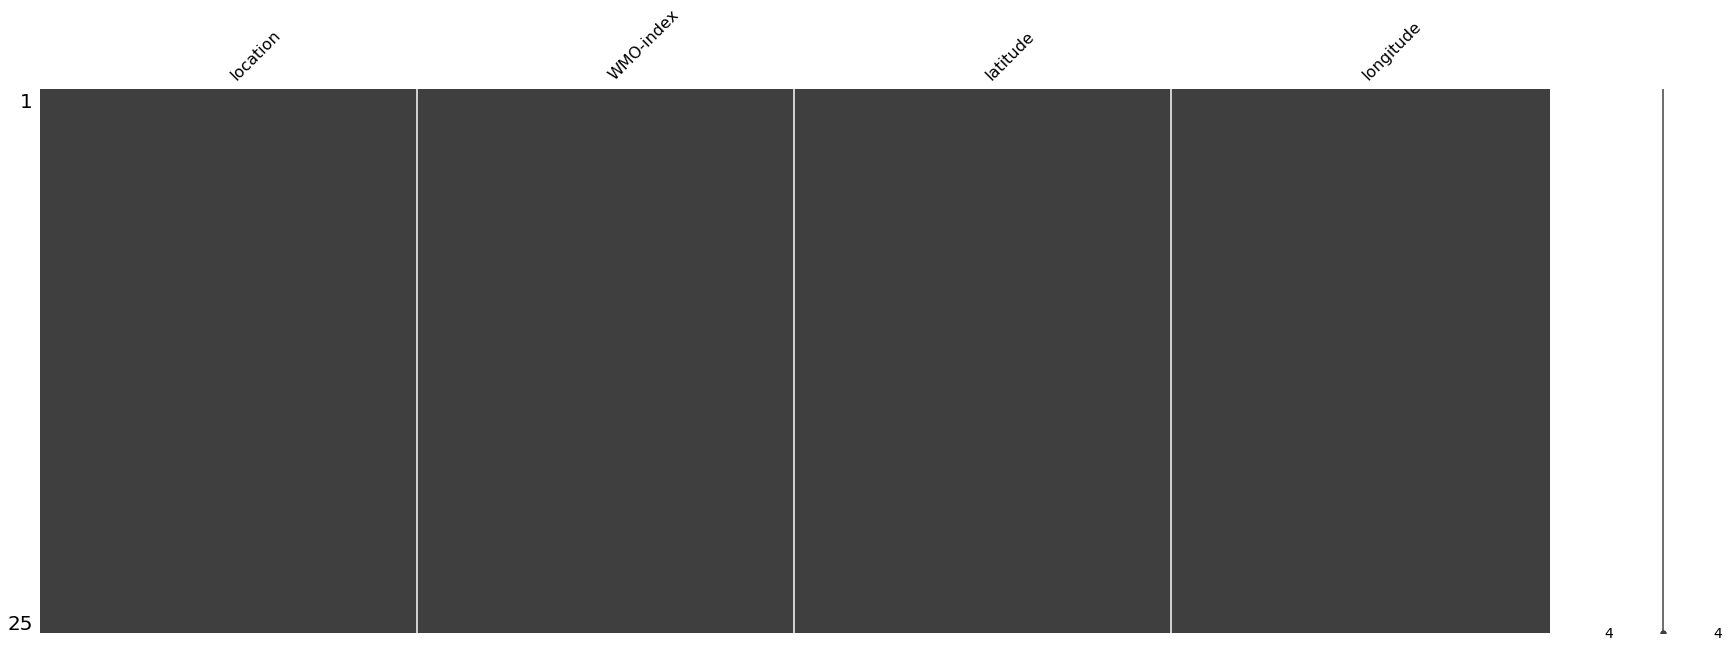

In [9]:
missingno.matrix(info_df, figsize = (30,10))

The info data is fully present.

#### pressure_df data

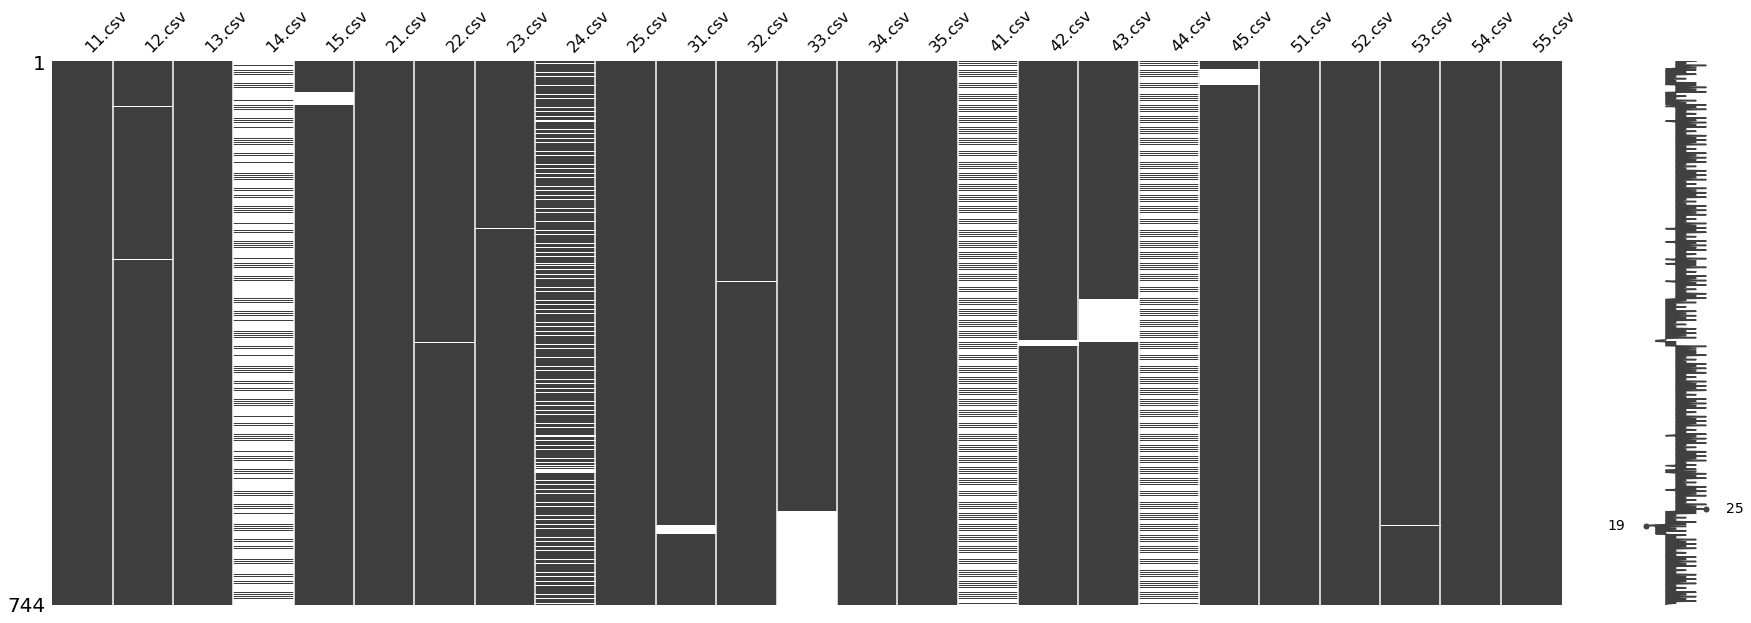

In [10]:
missingno.matrix(pressure_df, figsize = (30,10))

Seems like the data is mostly in good shape. Though, as noted before, there are some datasets with a few holes in them whole others have a not very high data density. 



#### dataholes

Lets first take a look at the holes in the datasets 33 and 45 and see if the event has still been documented:

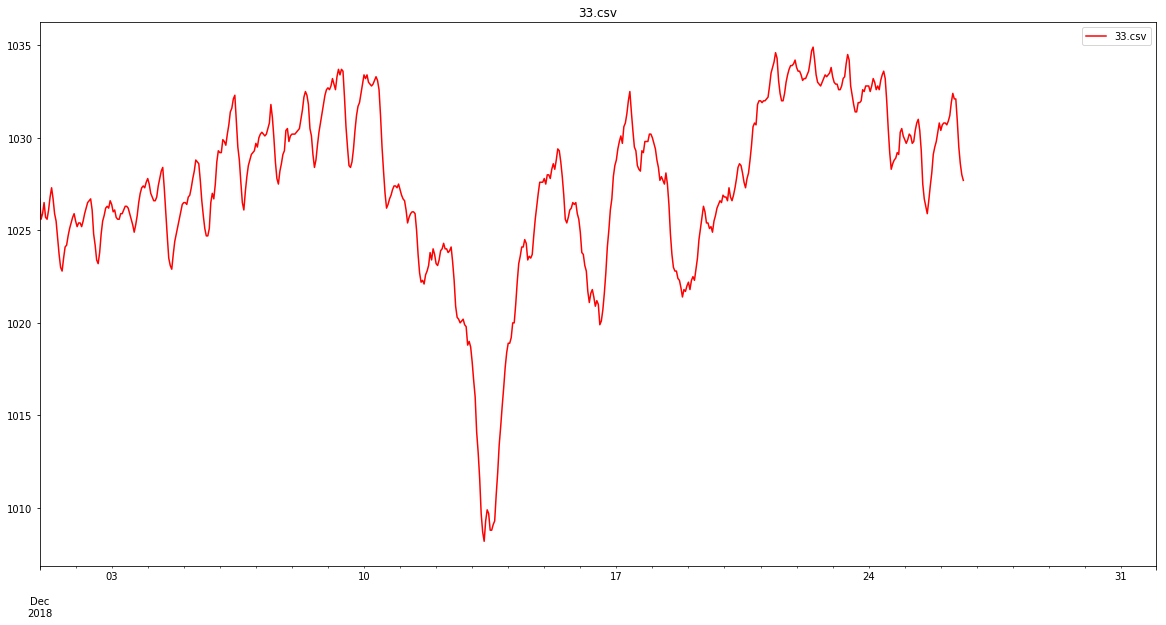

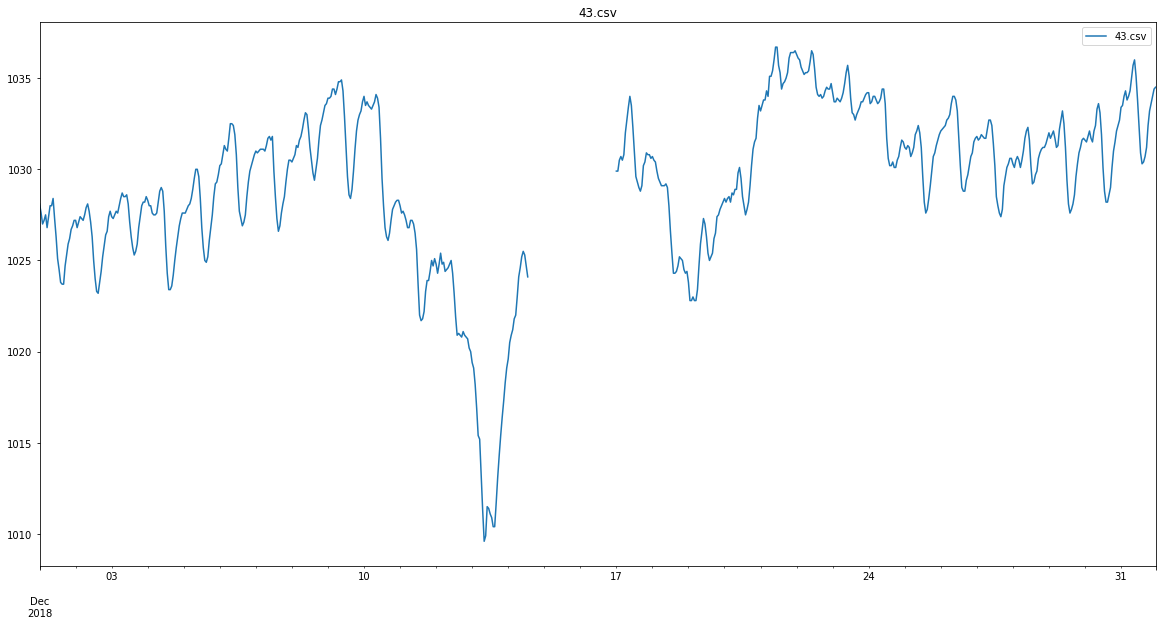

In [11]:
pressure_df.plot( y=['33.csv'],figsize=(20,10),title='33.csv',style='r-')
pressure_df.plot( y=['43.csv'],figsize=(20,10),title='43.csv')

The missing data from 33.csv doesnt matter to us but the hole right of the event in 43.csv might be bothersome.

#### low density datasets



It looks like the data in the 14.csv column has the lowest density. Lets plot it alongside a dense dataset, preferably from an adjacent quadrant on the map (like 15.csv) and see what we get:


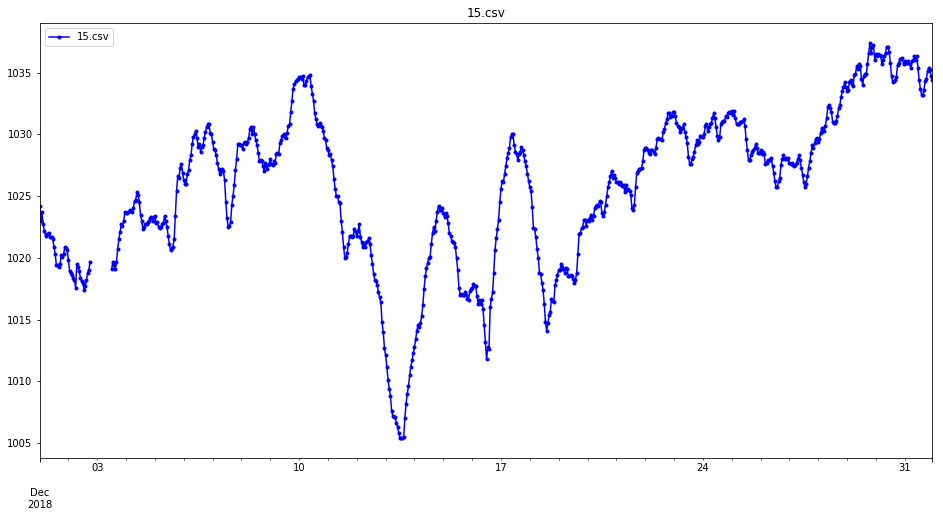

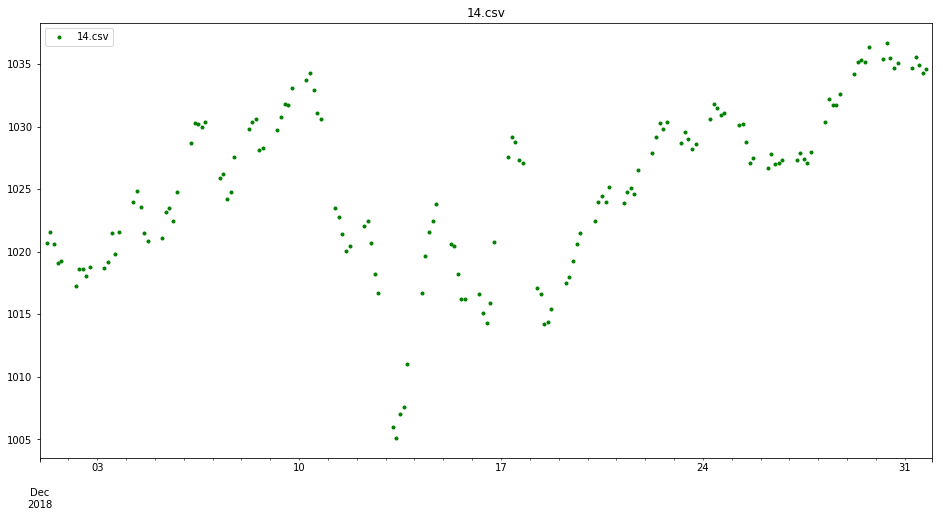

In [12]:
pressure_df.plot( y=['15.csv'],style='b.-',title='15.csv',figsize=(16,8))
pressure_df.plot( y=['14.csv'],style='g.',title='14.csv',figsize=(16,8))

We can see that though 14.csv is less detailed than 15.csv, both diagrams resemble each other quite well. The spikes on both diagrams close in at about the same values and the sharpness of the spikes is comparable as well. This means that the holes in 14.csv, which is the dataset with the lowest density, did not have a significant impact on the precision of the plotting, as compared to the densest datasets. 

This leads us to the conclusion, that we’ll be fine using all of our less dense data as it is, since even our worst dataset was good enough. 

We can still fill in the missing values though.

## filling missing values 

#### filling the datahole in 43.csv

We will stuff the hole with data from one of the adjacent quadrants. For that we will plot the data from the adjacent quadrants in the same diagram as 43 and see what fits best:

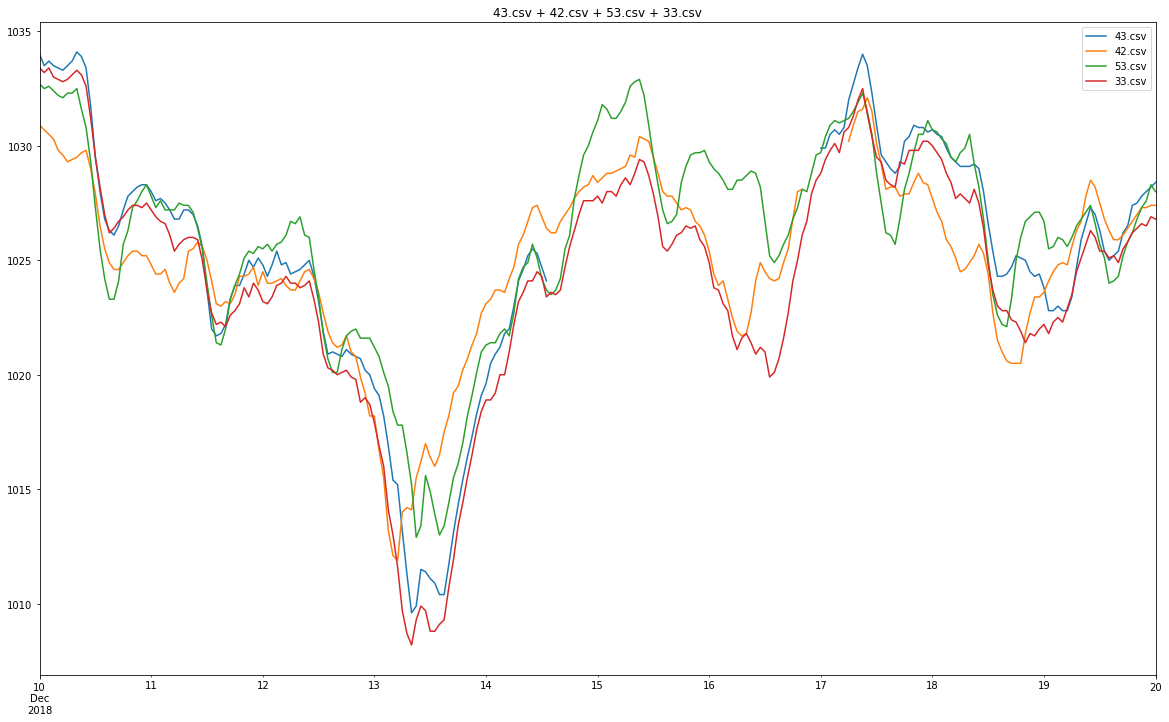

In [13]:
 pressure_df.loc['2018-12-10 00':'2018-12-20 00',:].plot( y=['43.csv','42.csv','53.csv','33.csv'],figsize=(20,12),
                                                         title='43.csv + ''42.csv + ''53.csv + ''33.csv')

The data from 33 seems like the best fit, so we’ll choose this one to replace the hole in 43.

In [14]:
pressure_df['43.csv'] = pressure_df['43.csv'].fillna(pressure_df['33.csv'])

Lets plot it and look at the result:

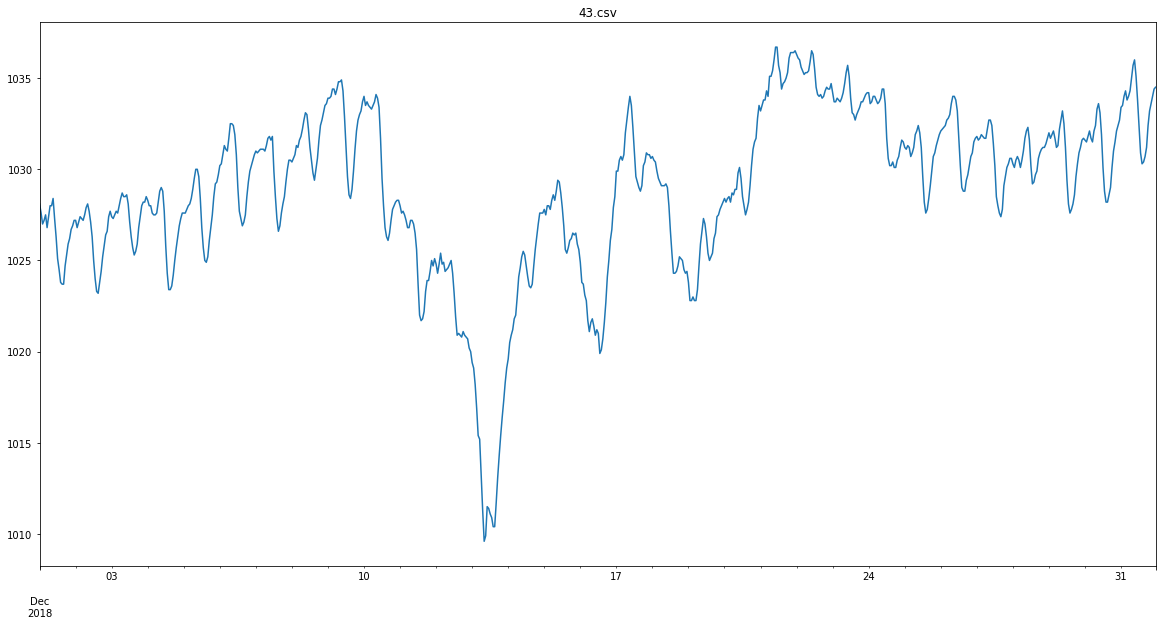

In [15]:
pressure_df['43.csv'].plot( figsize=(20,10),title='43.csv')

Looks good!

####  interpolating between values in 14.csv, 24.csv, 41.csv, 44.csv

Since precision is not too important, we will be using the simple linear interpolation method.

This is what 14.csv looks like after the filling of missing values:

In [16]:
pressure_df = pressure_df.interpolate().fillna(method='bfill').fillna(method='ffill')

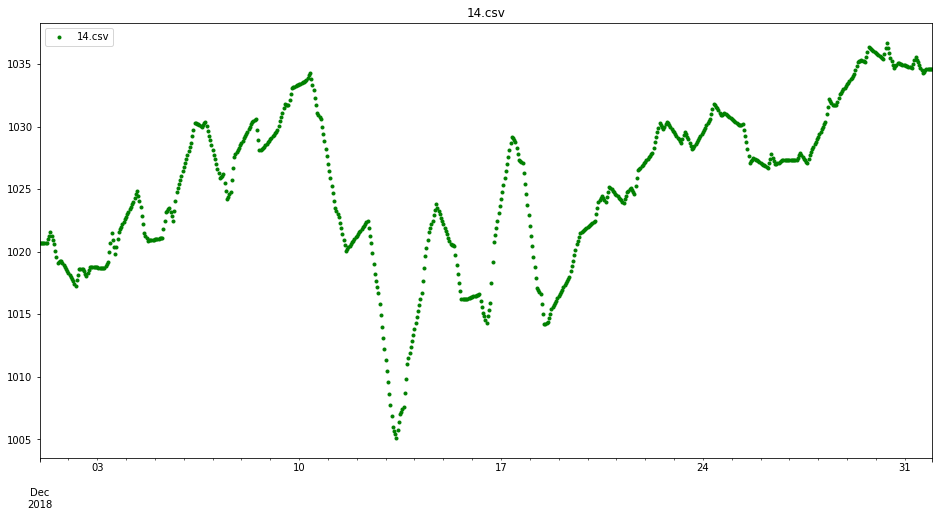

In [17]:
pressure_df.plot( y=['14.csv'],style='g.',title='14.csv',figsize=(16,8))

#### pressure_df data after treatment

Lets use the tool again to make sure we got all holes filled:

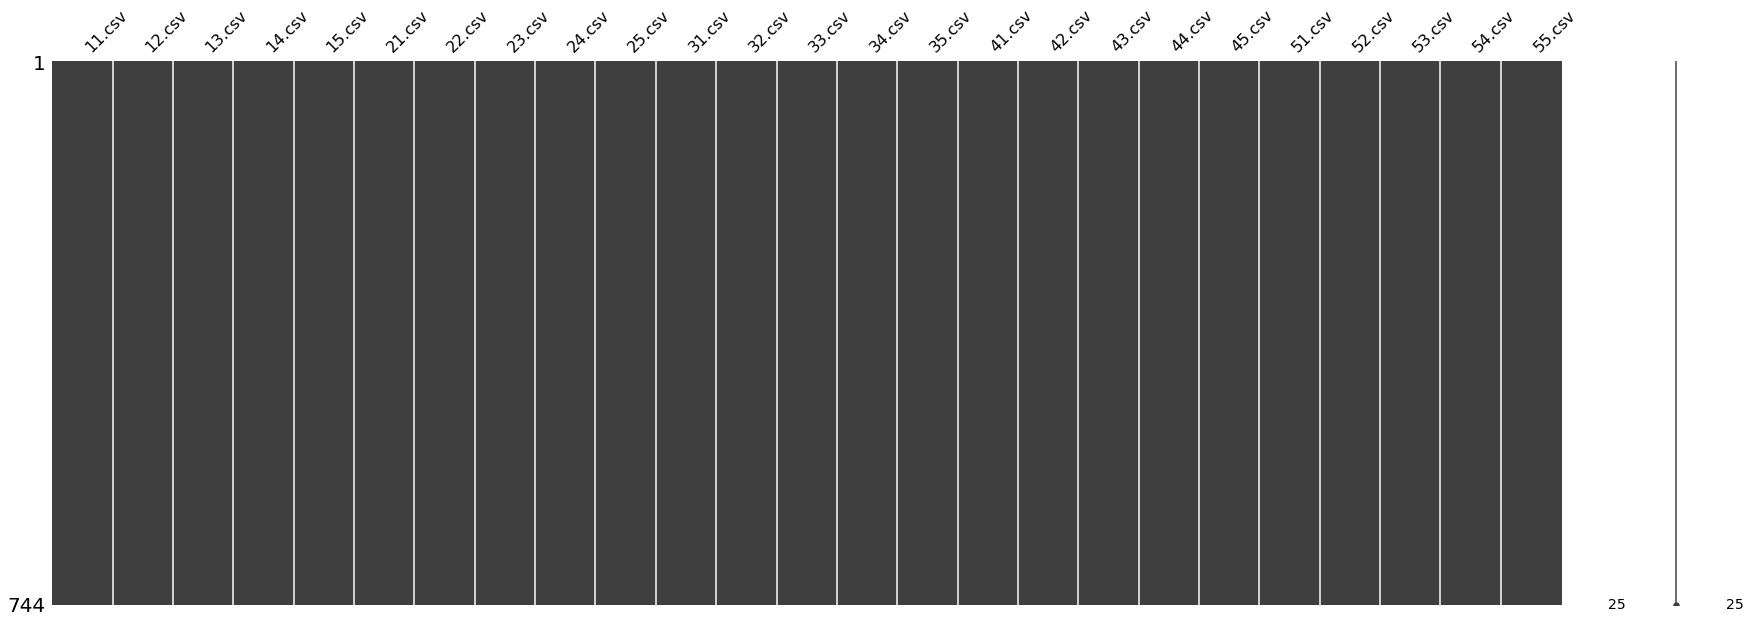

In [18]:
missingno.matrix(pressure_df, figsize = (30,10))

Looks good.

# analyzing the data

## First we will determine the time interval the event is acting in. 

#### For that we will plot all the data inside one diagram: 

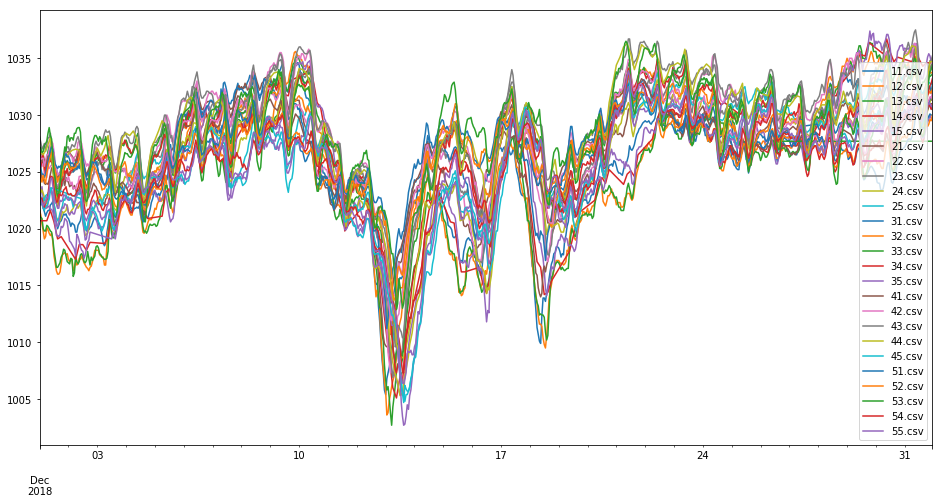

In [19]:
pressure_df.plot( figsize=(16,8))

Seems like the event is limited to the dates from '2018/12/12 00:00' to '2018/12/15 00:00' so lets zoom in on that interval:

#### zooming in on the event

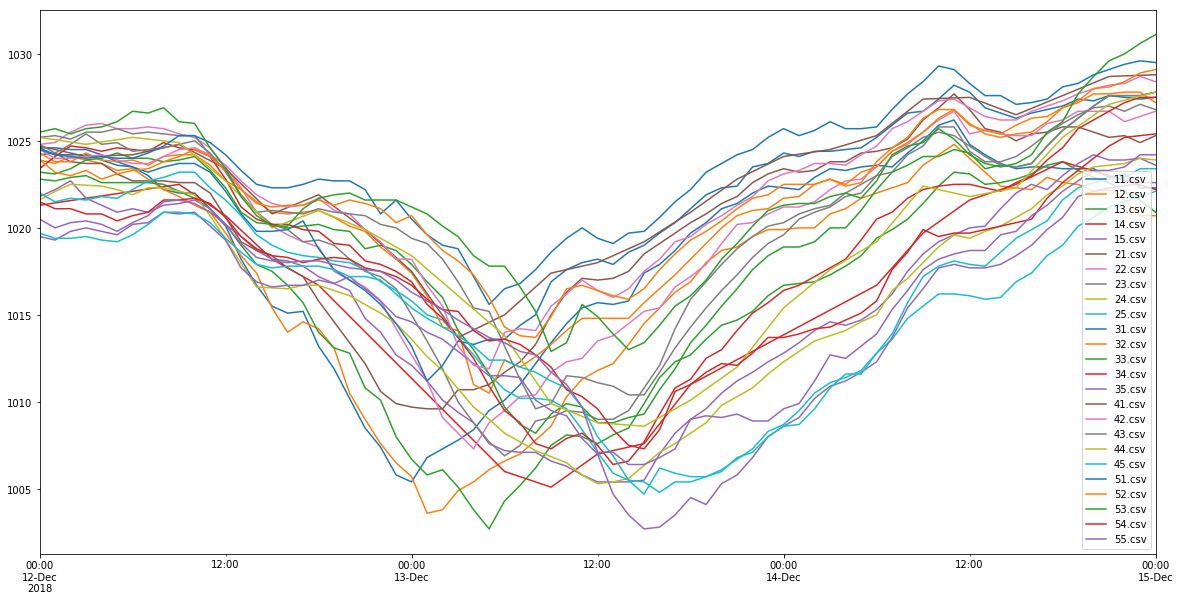

In [20]:
pressure_df.loc['2018-12-12 00':'2018-12-15 00',:].plot( figsize=(20,10))

The first low appears at '2018/12/13 00:00', the last low around '2018/12/13 16:00'. During this time the event center is inside the grid of the meteorological stations. So this will be the time interval we will be focusing on. 

Lets save this time-interval as a list for future use:

In [21]:
list_time_points_2h = pd.date_range('2018-12-13 00:00','2018-12-13 16:00',freq = '2H')

## visualizing the event

The next step will be to visualize the event progression to get a picture of the movement path and the radius of the event. For that we will use the pressure data from the different locations and plot it as a heatmap on a grid of geographical coordinates. We will do this for nine different points in times during the significant time interval. We will also interpolate the values in between the location with the bi-cubic method to compensate for the locations where we don’t have any data for. 

The darker the color, the lower the pressure and the shorter the distance to the event center will be. The point of lowest pressure on the map will artificially be made darker for the purpose of highlighting it.

In [22]:
# getting list of the location coordinates

list_location_coordinates = []
for x in list_csv_names:
    list_temp = [info_df.at[x,'longitude'],info_df.at[x,'latitude']]
    list_location_coordinates.append(list_temp)

list_location_coordinates =  np.array(list_location_coordinates)

In [23]:
# getting list of the pressure values

def list_pressurevalues(time_):
    list_temp = []
    for z in list_csv_names:
        list_temp.append(pressure_df.at[time_,z])
    return np.array(list_temp)

In [24]:
# making the grid

(grid_x, grid_y) = np.mgrid[-8.54:1.25:30j,36.42:43.73:30j]

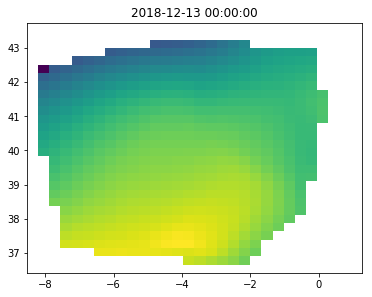

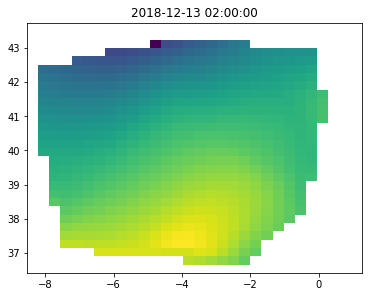

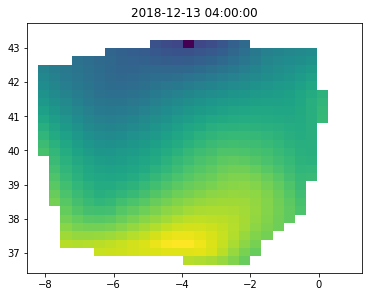

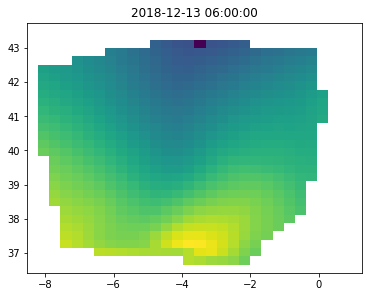

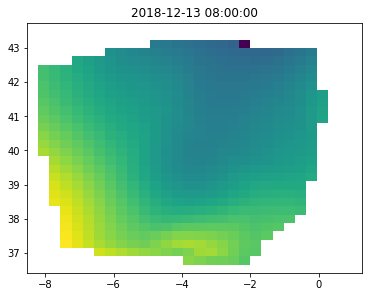

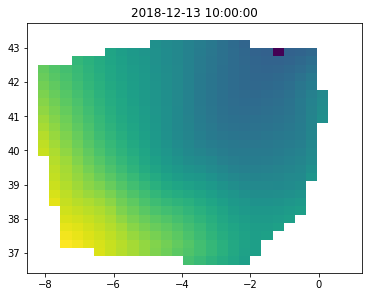

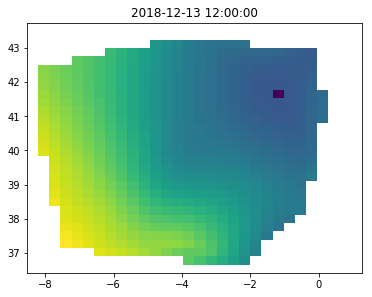

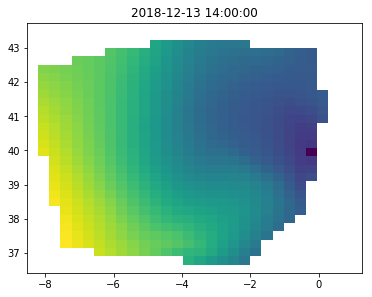

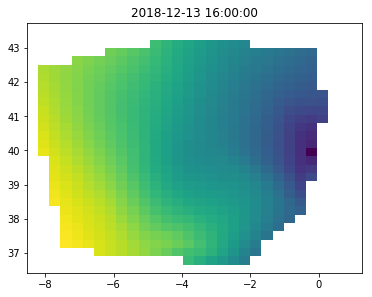

In [25]:
# plotting

for x in list_time_points_2h:
    grid_ = griddata(list_location_coordinates, list_pressurevalues(x), (grid_x, grid_y), method='cubic')
    grid_temp = griddata(list_location_coordinates, list_pressurevalues(x), (grid_x, grid_y), method='cubic')
    grid_temp[np.isnan(grid_temp)]=1015
    
    grid_[grid_ == np.amin(grid_temp)]=1000
    
    plt.imshow(grid_.T, extent=(-8.54,1.25,36.42,43.73), origin='lower')
    plt.title(x)
    plt.gcf().set_size_inches(6, 6)
    plt.show()


## zooming in on the time span when the event center is inside our weatherstation grid

It seems that unfortunately the event center was verifiably inside our grid of weather stations only during a short time window from '2018-12-13 10:00' to '2018-12-13 14:00'. Lets plot the data during this time with the higher 1hour frequency. While we are at it, we will also register the location of the event center and its pressure. 

In [26]:
# new list of points in time with higher frequency

list_time_points_1h = pd.date_range('2018-12-13 10:00','2018-12-13 14:00',freq = '1H')

In [27]:
# making data frame with info about event center

center_df = pd.DataFrame([],
                        index = list_time_points_1h,
                        columns = ['event_center_location [long/lat]','event_center_pressure'])
center_df

,event_center_location [long/lat],event_center_pressure
2018-12-13 10:00:00,NaN,NaN
2018-12-13 11:00:00,NaN,NaN
2018-12-13 12:00:00,NaN,NaN
2018-12-13 13:00:00,NaN,NaN
2018-12-13 14:00:00,NaN,NaN


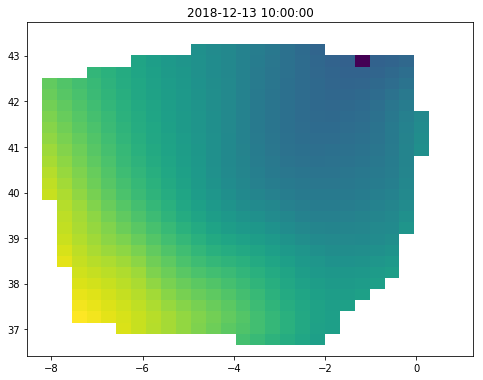

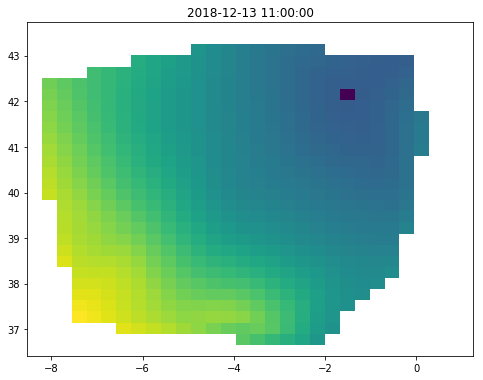

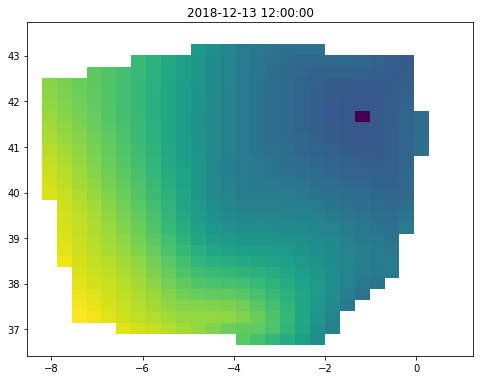

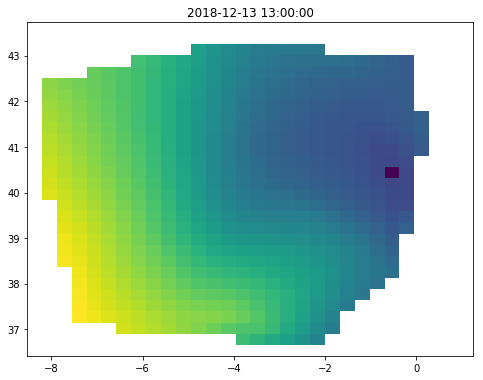

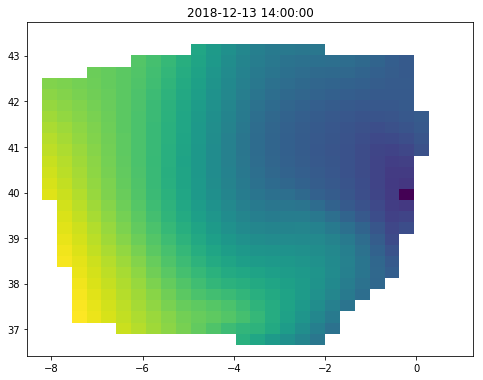

In [28]:
# plotting

for x in list_time_points_1h:
    grid_ = griddata(list_location_coordinates, list_pressurevalues(x), (grid_x, grid_y), method='cubic')
    grid_temp = griddata(list_location_coordinates, list_pressurevalues(x), (grid_x, grid_y), method='cubic')
    grid_temp[np.isnan(grid_temp)]=1030
    
    index_ = np.where(grid_temp == np.amin(grid_temp))
    center_df.at[x,'event_center_pressure'] = np.amin(grid_temp)
    center_df.at[x,'event_center_location [long/lat]'] = [-8.54 + (1.25-(-8.54))*(index_[0][0])/29, \
                                                            36.42 + (43.73-36.42)*(index_[1][0])/29]
    
    
    
    grid_[grid_ == np.amin(grid_temp)]=1000
    
    plt.imshow(grid_.T, extent=(-8.54,1.25,36.42,43.73), origin='lower')
    plt.title(x)
    plt.gcf().set_size_inches(8,8)
#     if str(x) == '2018-12-13 11:00:00':
#         plt.savefig('11_00.png', transparent=True)
    plt.show()
    

In [29]:
center_df

,event_center_location [long/lat],event_center_pressure
2018-12-13 10:00:00,"[-1.1131034482758615, 42.97379310344827]",1005.88
2018-12-13 11:00:00,"[-1.4506896551724138, 42.21758620689655]",1005.81
2018-12-13 12:00:00,"[-1.1131034482758615, 41.71344827586206]",1005.19
2018-12-13 13:00:00,"[-0.4379310344827587, 40.45310344827586]",1004.09
2018-12-13 14:00:00,"[-0.10034482758620733, 39.948965517241376]",1003.08


## calculating the event radius

Using the diagram from '2018-12-13 11:00' we can make an educated guess about the range of influence of the event. 

<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/Spain%20event%20radius.bmp"> 

Given a location we can calculate the length in meters of one degree of longitude/latitude at this location using the following formulas:

length in meters of a degree of latitude at latitude φ:

\begin{equation*}
s(1°latitude)[m] = 111132.92\, - \, 559.82\, cos(2\varphi )\, + \, 1.175\, cos(4\varphi )\, - \, 0.0023\, cos(6\varphi)\\
\end{equation*}

length in meters of a degree of longitude at longitude 𝜗:

\begin{equation*}
s(1°longitude)[m] = 111412.84\, cos(\vartheta )\,  - \, 93.5\, cos(3\vartheta )\, +  \, 0.118\, cos(5\varphi)\\
\end{equation*}

We know that Spain's location is roughly (40.4, -3.7). 
Lets calculate the length of 1° of longitude/latitude for Spain:

In [30]:
# calculating s(1°longitude @ -3.7)[m]
s_1d_long = 111412.84*math.cos(-3.7) - 93.5*math.cos(3*-3.7) + 0.118*math.cos(5*-3.7)
print( s_1d_long )

-94498.8683415211


In [31]:
# calculating s(1°latitude @ 40.4)[m]
s_1d_lat = 111132.92 - 559.82*math.cos(2*40.4) + 1.175*math.cos(4*40.4) - 0.0023*math.cos(6*40.4)
print( s_1d_lat )

110776.61612565823


Now we can calculate the length of the event radius using the theorem of Pythagoras:

In [32]:
# distance longitude in degrees
d_long_d = -1.45 - (-7.85)

# distance longitude in kilometers
d_long_km = d_long_d * -s_1d_long/1000
print(d_long_km)

604.792757385735


In [33]:
# distance latitude in degrees
d_lat_d = 43.76 - (42.22)

# distance latitude in kilometers
d_lat_km = d_lat_d * s_1d_lat/1000
print(d_lat_km)

170.5959888335136


In [34]:
# length radius = ( (distance longitude[km])^2 + (distance latitude[km])^2 )^(1/2)
l_radius_km = ( d_long_km**2 + d_lat_km**2 )**(.5)
print(round(l_radius_km,1))


628.4


### >>>  event radius = 628.4 km

## reconstructing the path of the event center from '2018-12-13 10:00' to '2018-12-13 14:00'

Unfortunately we will only be able to reconstruct the event movements for the time period the event center is inside our grid. 

For that we will simply plot the event center coordinates for every hour during that period on our map of spain:

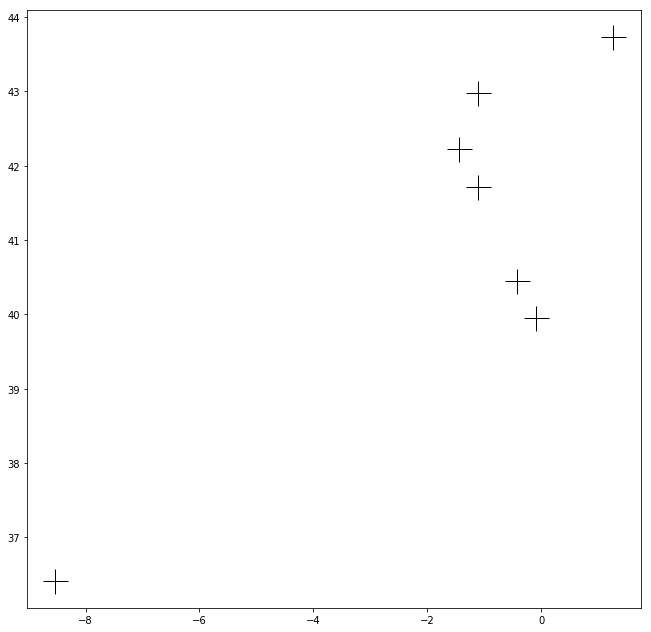

In [35]:
points = np.array(list(center_df.loc[:,'event_center_location [long/lat]']) + [[-8.54,36.42] , [1.25,43.73]])
plt.plot(points[:,0],points[:,1], 'k+',ms=25)
plt.gcf().set_size_inches(11,11)
# plt.savefig('center_movement.png', transparent=True)
plt.show()

<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/Spain%20event%20movement.bmp"> 

## event center speed

#### calculating the speed:
For that we will first calculate the distances to the next event center location for each location: 

In [36]:
center_df['distance_to_next_event_center[km]'] = np.nan
# for x in center_df.index[:-1]:
for x in range(len(center_df.index)-1):
    center_df['distance_to_next_event_center[km]'].iat[x] = ( ( (center_df['event_center_location [long/lat]'].iat[x][0] - \
                                                    center_df['event_center_location [long/lat]'].iat[x+1][0]) *(-s_1d_long/1000) )**2 + \
                                                    ( (center_df['event_center_location [long/lat]'].iat[x][1] - \
                                                    center_df['event_center_location [long/lat]'].iat[x+1][1]) *(s_1d_lat/1000) )**2 ) **.5

In [37]:
center_df

,event_center_location [long/lat],event_center_pressure,distance_to_next_event_center[km]
2018-12-13 10:00:00,"[-1.1131034482758615, 42.97379310344827]",1005.88,89.638867
2018-12-13 11:00:00,"[-1.4506896551724138, 42.21758620689655]",1005.81,64.316093
2018-12-13 12:00:00,"[-1.1131034482758615, 41.71344827586206]",1005.19,153.504590
2018-12-13 13:00:00,"[-0.4379310344827587, 40.45310344827586]",1004.09,64.316093
2018-12-13 14:00:00,"[-0.10034482758620733, 39.948965517241376]",1003.08,NaN


The event speed will be this distance divided by 1hour:

In [38]:
center_speed_df = pd.DataFrame([],
                        index = pd.date_range('2018-12-13 10:30','2018-12-13 13:30',freq = '60min'),
                        columns = ['event_center_speed[km/h]','average_event_center_speed[km/h]'])

center_speed_df['event_center_speed[km/h]'] = list(center_df['distance_to_next_event_center[km]'][:-1])
center_speed_df['average_event_center_speed[km/h]'] = sum(list(center_speed_df['event_center_speed[km/h]']))/len(center_speed_df.index)
center_speed_df

,event_center_speed[km/h],average_event_center_speed[km/h]
2018-12-13 10:30:00,89.638867,92.943911
2018-12-13 11:30:00,64.316093,92.943911
2018-12-13 12:30:00,153.504590,92.943911
2018-12-13 13:30:00,64.316093,92.943911


 ### >>> average event center speed = 92.9 km/h

#### plotting the speed

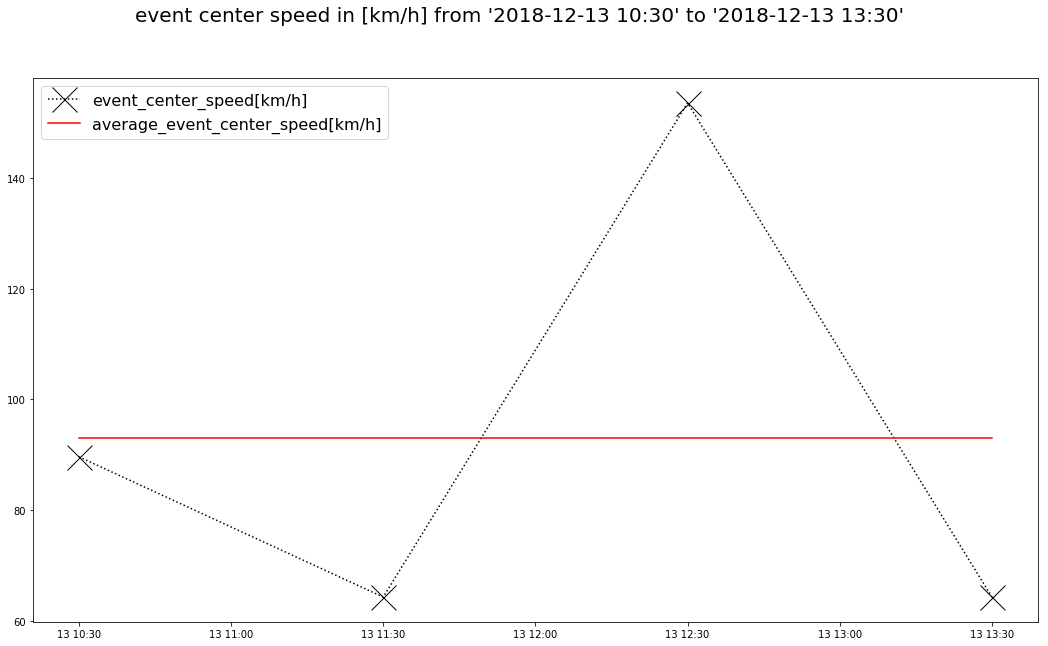

In [39]:
plt.plot( center_speed_df['event_center_speed[km/h]'],'x:k' ,ms=25)
plt.plot(center_speed_df['average_event_center_speed[km/h]'],'r')
plt.suptitle("event center speed in [km/h] from '2018-12-13 10:30' to '2018-12-13 13:30'", fontsize=20)
plt.legend(["event_center_speed[km/h]","average_event_center_speed[km/h]"],fontsize=16)
plt.gcf().set_size_inches(18,10)

The event speed seems to be highly varying, without any clear trend for the observed time interval.

## relative event strength progression (derived from event center pressure and P_base)

Plotting the event center pressure against time will give as way to judge the progression of the event strength:



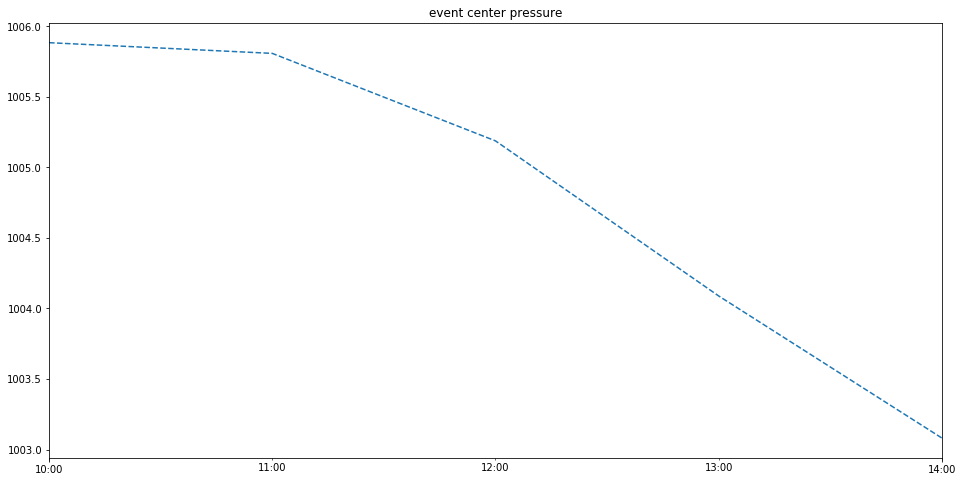

In [40]:
center_df['event_center_pressure'].plot(style='--',title='event center pressure',figsize=(16,8))

#### calculating P_base

We can clearly see from looking at the diagram above, that the center pressure is decreasing over time and therefore the event strength must be increasing. From that alone we will not be able to calculate the relative strength increase though. For that we will need to find the base pressure P_base. This is the pressure measured outside of the radius of the event. Lets see which stations were outside of it during the observed time interval. We will take their pressure measurements at that time and average them to get P_base:

<img align="right" src="https://raw.githubusercontent.com/51ngularity/weather/master/images/P_base.bmp"> 

Here we can see, that the stations 21, 31, 41, 51, and 52 have consistently been outside of the influence zone of the event and their pressure measurements should therefore be on base level during the observed time interval. Those are the stations whose data we'll be using to calculate P_base:

In [41]:
# collecting and averaging over pressure values from 21.csv, 31.csv, 41.csv, 51.csv, and 52.csv

list_temp = []
for y in ['21.csv', '31.csv', '41.csv', '51.csv', '52.csv']:
    for x in list_time_points_1h:
        list_temp.append(pressure_df[y][x])

P_base = sum(list_temp)/25
print('P_base = %.1f' %(P_base))

P_base = 1017.8


### >>> P_base = 1017.8

Using P_base we can calculate and plot the relative changes in (P_base - P_center):

In [42]:
center_df['relative_event_srength[%]'] = (P_base - center_df['event_center_pressure'][:])/(P_base - center_df['event_center_pressure'][0])*100

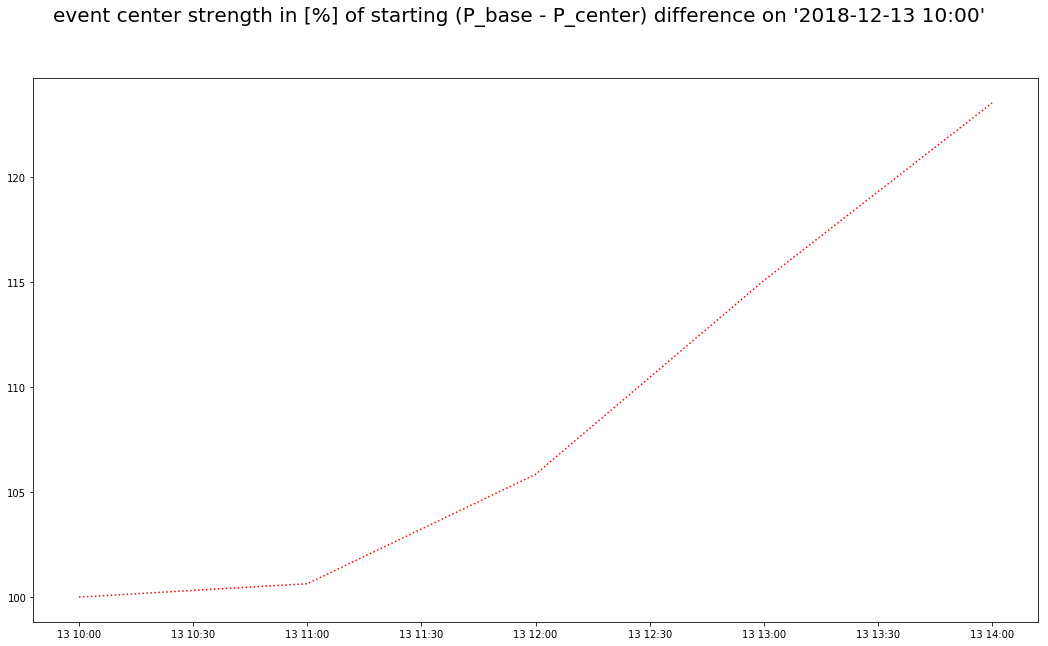

In [43]:
plt.plot( center_df['relative_event_srength[%]'],':r' ,ms=25)

plt.suptitle("event center strength in [%] of starting (P_base - P_center) difference on '2018-12-13 10:00'", fontsize=20)
plt.gcf().set_size_inches(18,10)

As we can see 
### >>> during the observed time interval the event is rapidly gaining in power at a rate of about (5%)/hour

## conclusion

Overall the project was a success. It has been possible – as predicted – to reconstruct the events’ path, speed, radius and relative strength progression, even though only for a short time interval of a few hours.

Unfortunately the event center was outside of the weather-station grid for most of the time span, for which we had data available and thus this data could not be used to help us analyze the event center movement. This could have been avoided by using a larger station grid / using data from stations in a larger area. 

Another area of potential improvement would be the construction of the weather-station grid. It was in place among other things to indicate the lines of constant longitude / altitude angles. But it has been overlooked, that at the location of Spain the lines of constant longitude angles do not run in parallel to each other. The station grid should therefore not have been made of parallel vertical lines either. It should have looked more like a trapeze. This blunder has surely been a source of inaccuracies for the calculations which used grid coordinates.  